# Classical classifiers

This notebook shows how well classical classifiers solve the sentence classification problem that is chosen for the pre-alpha prototype. This is mainly needed to have a baseline for quantum solution to compare against.

We first load our library files and the required packages.

In [12]:
import sys
import os
import json
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append("../../models/classical/")

from NNClassifier import (loadData,evaluate, NNClassifier,
       prepareTrainTestXYWords, prepareTrainTestXYSentence,)

For data vectorizing separate services are used which are run as Docker containers. To simplify the presentation via Jupyter notebook, for demonstration we will just load the already vectorized data.

We have implemented sentence vectorization using pretrained _BERT_ (see [Git](https://github.com/google-research/bert), [arXiv](https://arxiv.org/abs/1810.04805)) base model (each sentence is represented as a 768-dimensional real-valued vector),
as well as word-level vectorization using [_fastText_](https://fasttext.cc/) model [pretrained on English Wikipedia](https://fasttext.cc/docs/en/pretrained-vectors.html) (each word in a sentence is represented as a 300-dimensional real-valued vector).

We will start with the BERT sentence-level vectorization.

In [13]:
data = loadData("../../data/dataset_vectorized_bert_uncased.json")
print(f"Training samples: {len(data['train_data'])}, test samples: {len(data['test_data'])}")
print(f"An example sentence: {data['train_data'][2]['sentence']}, type: {data['train_data'][2]['sentence_type']}, truth value: {data['train_data'][2]['truth_value']}")
print(f"Vectorized sentence dimension: {len(data['train_data'][0]['sentence_vectorized'][0])}")

Training samples: 89, test samples: 23
An example sentence: chicken eats fox, type: NOUN-TVERB-NOUN, truth value: False
Vectorized sentence dimension: 768


We reformat the data as numpy arrays for classifier training. 

In [14]:
trainX, trainY, testX, testY = prepareTrainTestXYSentence(data)
print(f"{trainX.shape}")
print(f"{trainY.shape}")
print(f"{testX.shape}")
print(f"{testY.shape}")

(89, 768)
(89, 2)
(23, 768)
(23, 2)


We test the accuracy of classifying the sentence with the label corresponding to the closest sentence in the training data.

In [15]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(trainX, trainY)
res = neigh.predict(testX)
bert_neigh_test_acc = np.sum(res == testY)/2/len(testY)
bert_neigh_train_acc = neigh.score(trainX, trainY)
print(f"Nearest neighbor test accuracy: {bert_neigh_test_acc}, train accuracy: {bert_neigh_train_acc}")

Nearest neighbor test accuracy: 0.6956521739130435, train accuracy: 0.9887640449438202


Now we train a feedforward neural network classifier.

In [16]:
classifier = NNClassifier()
history = classifier.train(trainX, trainY)

Epoch 1/100
3/3 - 0s - loss: 0.7100 - accuracy: 0.5169 - 220ms/epoch - 73ms/step
Epoch 2/100
3/3 - 0s - loss: 0.6822 - accuracy: 0.5618 - 25ms/epoch - 8ms/step
Epoch 3/100
3/3 - 0s - loss: 0.6659 - accuracy: 0.6517 - 24ms/epoch - 8ms/step
Epoch 4/100
3/3 - 0s - loss: 0.6538 - accuracy: 0.6517 - 25ms/epoch - 8ms/step
Epoch 5/100
3/3 - 0s - loss: 0.6374 - accuracy: 0.6854 - 23ms/epoch - 8ms/step
Epoch 6/100


2022-11-01 12:54:25.682413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 - 0s - loss: 0.6270 - accuracy: 0.7079 - 31ms/epoch - 10ms/step
Epoch 7/100
3/3 - 0s - loss: 0.6177 - accuracy: 0.6517 - 24ms/epoch - 8ms/step
Epoch 8/100
3/3 - 0s - loss: 0.6115 - accuracy: 0.6517 - 24ms/epoch - 8ms/step
Epoch 9/100
3/3 - 0s - loss: 0.5986 - accuracy: 0.6517 - 30ms/epoch - 10ms/step
Epoch 10/100
3/3 - 0s - loss: 0.5915 - accuracy: 0.7191 - 31ms/epoch - 10ms/step
Epoch 11/100
3/3 - 0s - loss: 0.5855 - accuracy: 0.7640 - 29ms/epoch - 10ms/step
Epoch 12/100
3/3 - 0s - loss: 0.5803 - accuracy: 0.7528 - 28ms/epoch - 9ms/step
Epoch 13/100
3/3 - 0s - loss: 0.5714 - accuracy: 0.7191 - 28ms/epoch - 9ms/step
Epoch 14/100
3/3 - 0s - loss: 0.5697 - accuracy: 0.6854 - 28ms/epoch - 9ms/step
Epoch 15/100
3/3 - 0s - loss: 0.5605 - accuracy: 0.7191 - 28ms/epoch - 9ms/step
Epoch 16/100
3/3 - 0s - loss: 0.5533 - accuracy: 0.7303 - 22ms/epoch - 7ms/step
Epoch 17/100
3/3 - 0s - loss: 0.5499 - accuracy: 0.7303 - 35ms/epoch - 12ms/step
Epoch 18/100
3/3 - 0s - loss: 0.5432 - accuracy: 0.

In [6]:
bert_nn_train_acc = history.history["accuracy"][-1]
print(f"FNN train accuracy on BERT vectors: {bert_nn_train_acc}")

FNN train accuracy on BERT vectors: 0.865168571472168


And measure the accuracy on the test set.

In [7]:
res = classifier.predict(testX)
bert_nn_test_acc = evaluate(res, testY)
print(f"FFNN test accuracy on BERT vectors: {bert_nn_test_acc}")

1/1 [==============================] - 0s 105ms/step
FFNN test accuracy on BERT vectors: 0.6521739130434783


2022-11-01 12:53:47.841048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Depending on random, the NN classifier might perform better or worse (or the same) than the 1-nearest neighbor algorithm.

Now we load fastText word embeddings and train a convolutional network on them.

In [8]:
data = loadData("../../data/dataset_vectorized_fasttext.json")

maxLen = 5
trainX, trainY, testX, testY = prepareTrainTestXYWords(data, maxLen)

classifier = NNClassifier(model="CNN", vectorSpaceSize=300)
history = classifier.train(trainX, trainY)

Epoch 1/30


2022-11-01 12:53:48.221930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 - 1s - loss: 0.7924 - accuracy: 0.4944 - 620ms/epoch - 207ms/step
Epoch 2/30
3/3 - 0s - loss: 0.6302 - accuracy: 0.6966 - 52ms/epoch - 17ms/step
Epoch 3/30
3/3 - 0s - loss: 0.5488 - accuracy: 0.7640 - 31ms/epoch - 10ms/step
Epoch 4/30
3/3 - 0s - loss: 0.4981 - accuracy: 0.7528 - 33ms/epoch - 11ms/step
Epoch 5/30
3/3 - 0s - loss: 0.5099 - accuracy: 0.7079 - 34ms/epoch - 11ms/step
Epoch 6/30
3/3 - 0s - loss: 0.4721 - accuracy: 0.7303 - 31ms/epoch - 10ms/step
Epoch 7/30
3/3 - 0s - loss: 0.4752 - accuracy: 0.7303 - 30ms/epoch - 10ms/step
Epoch 8/30
3/3 - 0s - loss: 0.4024 - accuracy: 0.8539 - 31ms/epoch - 10ms/step
Epoch 9/30
3/3 - 0s - loss: 0.4059 - accuracy: 0.8202 - 33ms/epoch - 11ms/step
Epoch 10/30
3/3 - 0s - loss: 0.3396 - accuracy: 0.8764 - 31ms/epoch - 10ms/step
Epoch 11/30
3/3 - 0s - loss: 0.3318 - accuracy: 0.9101 - 29ms/epoch - 10ms/step
Epoch 12/30
3/3 - 0s - loss: 0.3407 - accuracy: 0.8315 - 30ms/epoch - 10ms/step
Epoch 13/30
3/3 - 0s - loss: 0.2885 - accuracy: 0.8652 - 3

In [17]:
fasttext_nn_train_acc = history.history['accuracy'][-1]
print(f"CNN train accuracy on fastText vectors: {fasttext_nn_train_acc}")

CNN train accuracy on fastText vectors: 0.8539326190948486


In [18]:
res = classifier.predict(testX)
fasttext_nn_test_acc = evaluate(res, testY)
print(f"CNN test accuracy on fastText vectors: {fasttext_nn_test_acc}")

1/1 [==============================] - 0s 37ms/step
CNN test accuracy on fastText vectors: 0.6956521739130435


2022-11-01 12:54:37.972503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Typically the convolutional network performs better than the previous algorithms.

Here is the whole set of results plotted

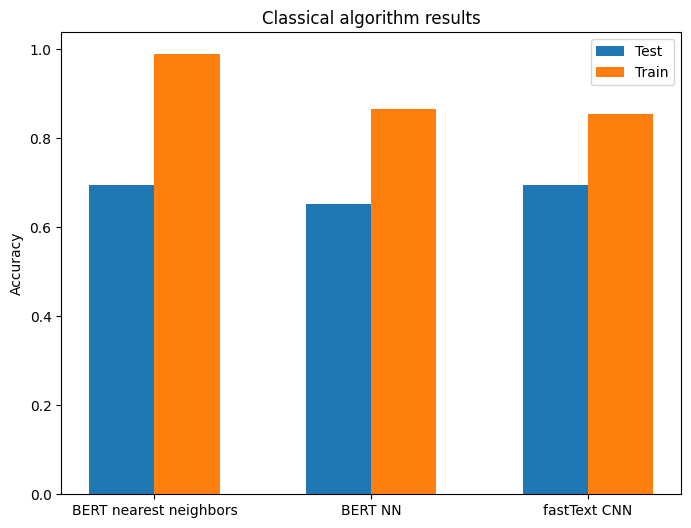

In [19]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
test_accs = [bert_neigh_test_acc, bert_nn_test_acc, fasttext_nn_test_acc]
train_accs = [bert_neigh_train_acc, bert_nn_train_acc, fasttext_nn_train_acc]
labels = ["BERT nearest neighbors", "BERT NN", "fastText CNN"]
width = 0.3
plt.bar(np.arange(len(test_accs)) - (width/2), test_accs, width=width)
plt.bar(np.arange(len(train_accs)) + (width/2), train_accs, width=width)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Accuracy")
plt.title("Classical algorithm results")
plt.legend(["Test", "Train"])
plt.show()

A promising future direction to explore seems to be implementing vectorizing using BERT that outputs word embeddings for each word in a sentence and training a convolutional network on top of them.